# 25_web_app - Jia

##  Predecir en base a medidas diagnósticas si un paciente tiene o no diabetes

## Paso 0: Importar Librerias

In [2]:
# Importacion de Librerias
# Registros y serialización
import logging
import pickle

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

# Modelado y evaluación
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)

# Pipelines
from sklearn.pipeline import Pipeline

# Preprocesamiento
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)

# Árboles de decisión
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)

# Métricas
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)

# Inspección
from sklearn.inspection import permutation_importance

# Configuración del registro
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

## Paso 1: Carga del dataset

In [3]:
#url = ('https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html')
#df_raw = pd.read_csv(url)

X, y = load_iris(return_X_y=True, as_frame=True)
df_raw = X
df_raw['species'] = y
df_raw.info()

#df_raw = sns.load_dataset("iris")
#df_raw.info()
df_raw.sample(10, random_state= 2025)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
2,4.7,3.2,1.3,0.2,0
148,6.2,3.4,5.4,2.3,2
112,6.8,3.0,5.5,2.1,2
132,6.4,2.8,5.6,2.2,2
0,5.1,3.5,1.4,0.2,0
113,5.7,2.5,5.0,2.0,2
34,4.9,3.1,1.5,0.2,0
51,6.4,3.2,4.5,1.5,1
135,7.7,3.0,6.1,2.3,2
5,5.4,3.9,1.7,0.4,0


In [33]:
q1 = df_raw.quantile(0.25)
q3 = df_raw.quantile(0.75)
iqr = q3-q1
lower_range = q1-(1.5*iqr)
upper_range = q3+(1.5*iqr)
print(df_raw.agg(['max','min']))
print (f'Upper Range: {upper_range}')
print (f'Lower Range: {lower_range}')

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
max                7.9               4.4                6.9               2.5   
min                4.3               2.0                1.0               0.1   

     species  
max        2  
min        0  
Upper Range: sepal length (cm)     8.35
sepal width (cm)      4.05
petal length (cm)    10.35
petal width (cm)      4.05
species               5.00
dtype: float64
Lower Range: sepal length (cm)    3.15
sepal width (cm)     2.05
petal length (cm)   -3.65
petal width (cm)    -1.95
species             -3.00
dtype: float64



## Paso 2: Data preprocessing

In [4]:
df_baking = df_raw.copy()
#df_baking['species'] = df_baking['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_baking['species'] = df_baking['species'].astype("category")

In [5]:
display(df_baking.describe(include='number').T)
display(df_baking.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


,count,unique,top,freq
species,150,3,0,50


In [6]:
df_baking.isna().sum()
df_baking.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

In [7]:
df_y = df_baking['species']
df_y.value_counts()

species
0    50
1    50
2    50
Name: count, dtype: int64

In [8]:
df = df_baking.copy()



## Paso 3: Exploratory Data Analysis

In [9]:
#División de los datos en entrenamiento y prueba
df_train, df_test = train_test_split(df, random_state=2025,test_size=0.2)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  120 non-null    float64 
 1   sepal width (cm)   120 non-null    float64 
 2   petal length (cm)  120 non-null    float64 
 3   petal width (cm)   120 non-null    float64 
 4   species            120 non-null    category
dtypes: category(1), float64(4)
memory usage: 4.1 KB


In [10]:
display(df_train.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),120.0,5.865000,0.826113,4.3,5.200,5.8,6.425,7.9
sepal width (cm),120.0,3.022500,0.443148,2.0,2.775,3.0,3.300,4.4
petal length (cm),120.0,3.809167,1.718559,1.0,1.575,4.3,5.100,6.9
petal width (cm),120.0,1.205833,0.735338,0.1,0.300,1.3,1.800,2.5


Analisis univariado

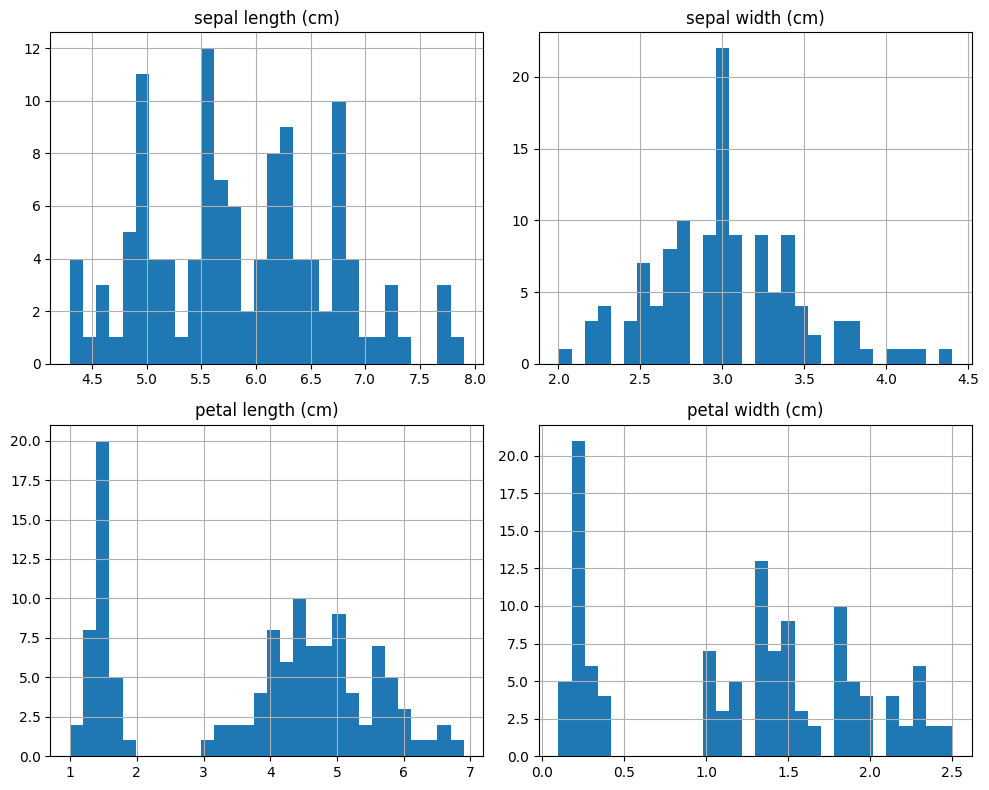

In [11]:
df_train.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

- Analisis bivariado

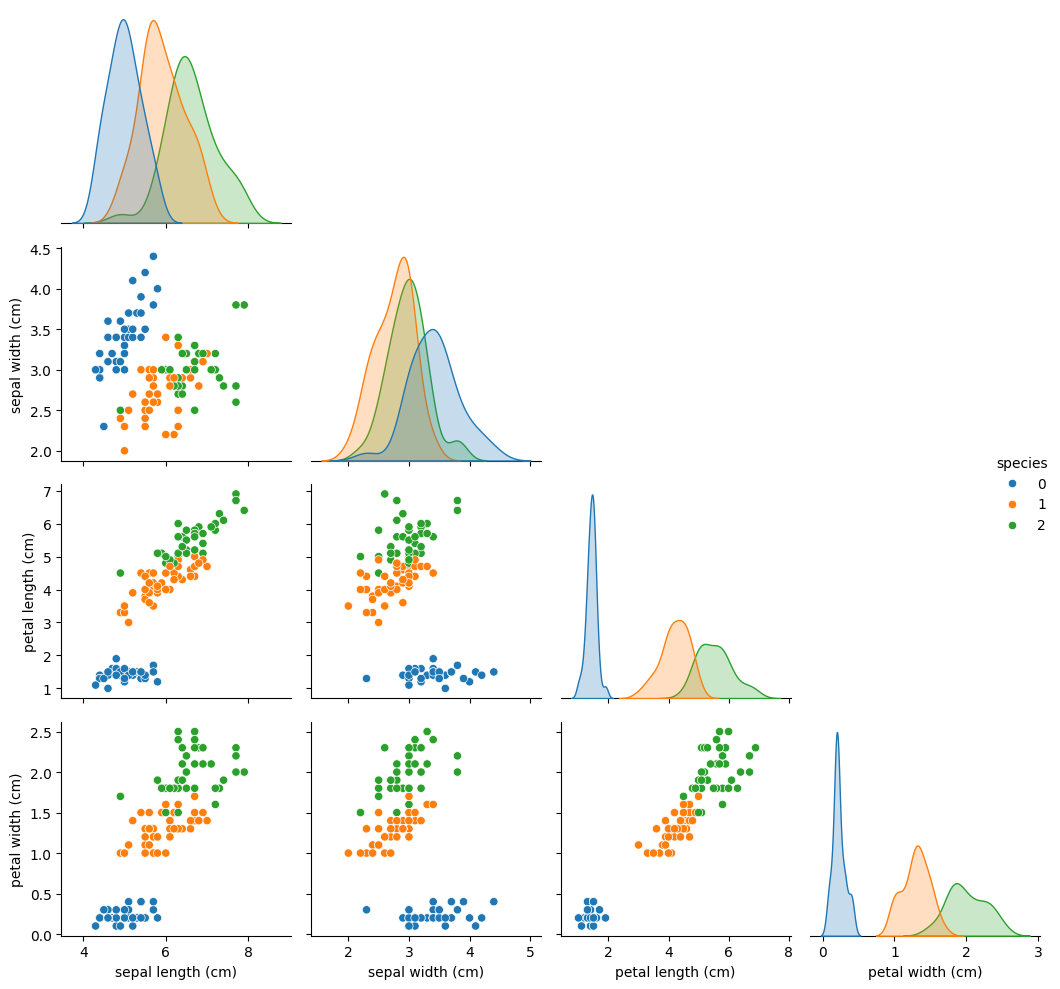

In [12]:
sns.pairplot(data=df_train,hue='species', corner=True)
plt.tight_layout()
plt.show()

- Correalaciones

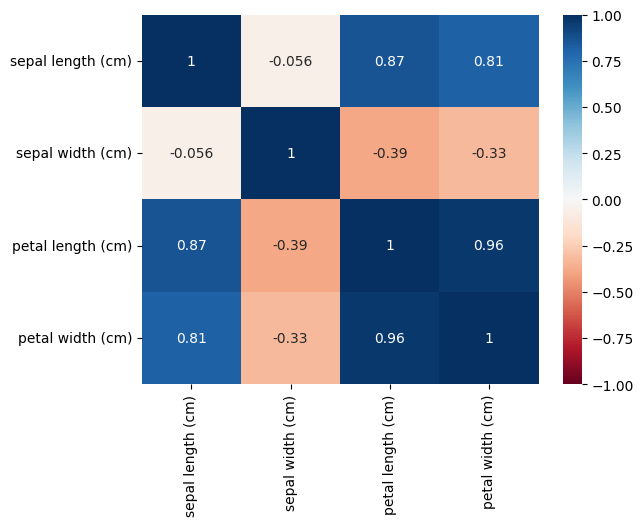

In [13]:
sns.heatmap(data=df_train.select_dtypes('number').corr(),vmin=-1,vmax=1,cmap='RdBu',annot=True)
plt.show()

## Paso 4: Machine Learning

In [14]:
X_train = df_train.drop(['species'],axis=1)
y_train = df_train['species']

X_test = df_test.drop(['species'],axis=1)
y_test = df_test['species']

display(X_train.head())
display(y_train.head())



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.4,2.8,5.6,2.1
1,6.5,3.0,5.8,2.2
2,6.1,3.0,4.6,1.4
3,4.9,2.4,3.3,1.0
4,6.3,2.7,4.9,1.8


0    2
1    2
2    1
3    1
4    2
Name: species, dtype: category
Categories (3, int64): [0, 1, 2]

In [15]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [16]:
y_hat = clf_tree.predict(X_test)
y_hat

array([0, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 0, 0, 1, 0, 2, 2, 2])

In [17]:
print(f"Accuracy: {accuracy_score(y_test, y_hat):.2f}")
#print(  f"F1 Score: {f1_score(y_test, y_hat):.2f}")

Accuracy: 0.93


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.60      0.75         5
           2       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.87      0.89        30
weighted avg       0.94      0.93      0.93        30



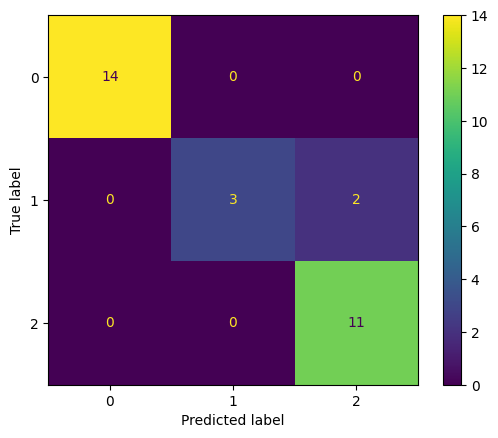

In [18]:
fig,ax = plt.subplots()
print(classification_report(y_test, y_hat))
ConfusionMatrixDisplay.from_predictions(y_test, y_hat,ax=ax)
plt.show()

Interpretación:

   -  Accuracy: El modelo tiene una precisión del 74%, lo que significa que el 74% de las predicciones fueron correctas.
   -  Precision: La precisión del modelo es del 69%, lo que indica que el 69% de las predicciones positivas fueron correctas.
   -  Recall (Sensibilidad): La sensibilidad del modelo es del 65%, lo que significa que el 65% de los casos positivos reales fueron correctamente identificados.
   -  F1 Score: La puntuación F1 es del 67%, que es una medida combinada de precisión y sensibilidad.


In [19]:
#plt.figure(figsize=(20,20))
#plot_tree(clf_tree, feature_names=X_train.columns, rounded= True,class_names=['0','1','2'], filled=True)
#plt.tight_layout()
#plt.show()

## Paso 5: Ajuste del modelo

In [20]:
clf_tree = DecisionTreeClassifier(
    class_weight="balanced", #Pondera ambas clases y le da mas peso a la clase minoritaria y menos peso a la mayoritaria
    max_depth=3 #Ajusta la cantidad de niveles a 3
    )
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

In [21]:
y_hat = clf_tree.predict(X_test)
y_hat

array([0, 2, 2, 2, 0, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 0, 0, 1, 0, 2, 2, 2])

In [22]:
print(f"Accuracy: {accuracy_score(y_test, y_hat):.2f}")
#print(  f"F1 Score: {f1_score(y_test, y_hat):.2f}")

Accuracy: 0.93


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.60      0.75         5
           2       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.87      0.89        30
weighted avg       0.94      0.93      0.93        30



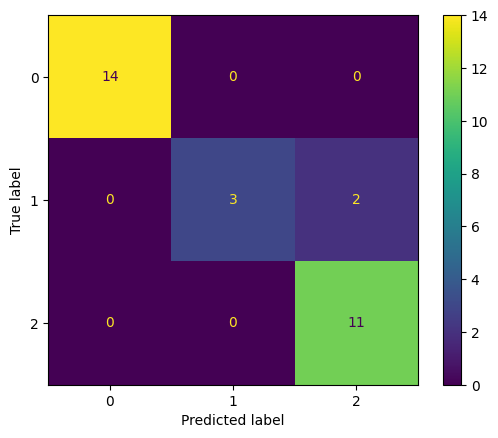

In [23]:
fig,ax = plt.subplots()
print(classification_report(y_test, y_hat))
ConfusionMatrixDisplay.from_predictions(y_test, y_hat,ax=ax)
plt.show()

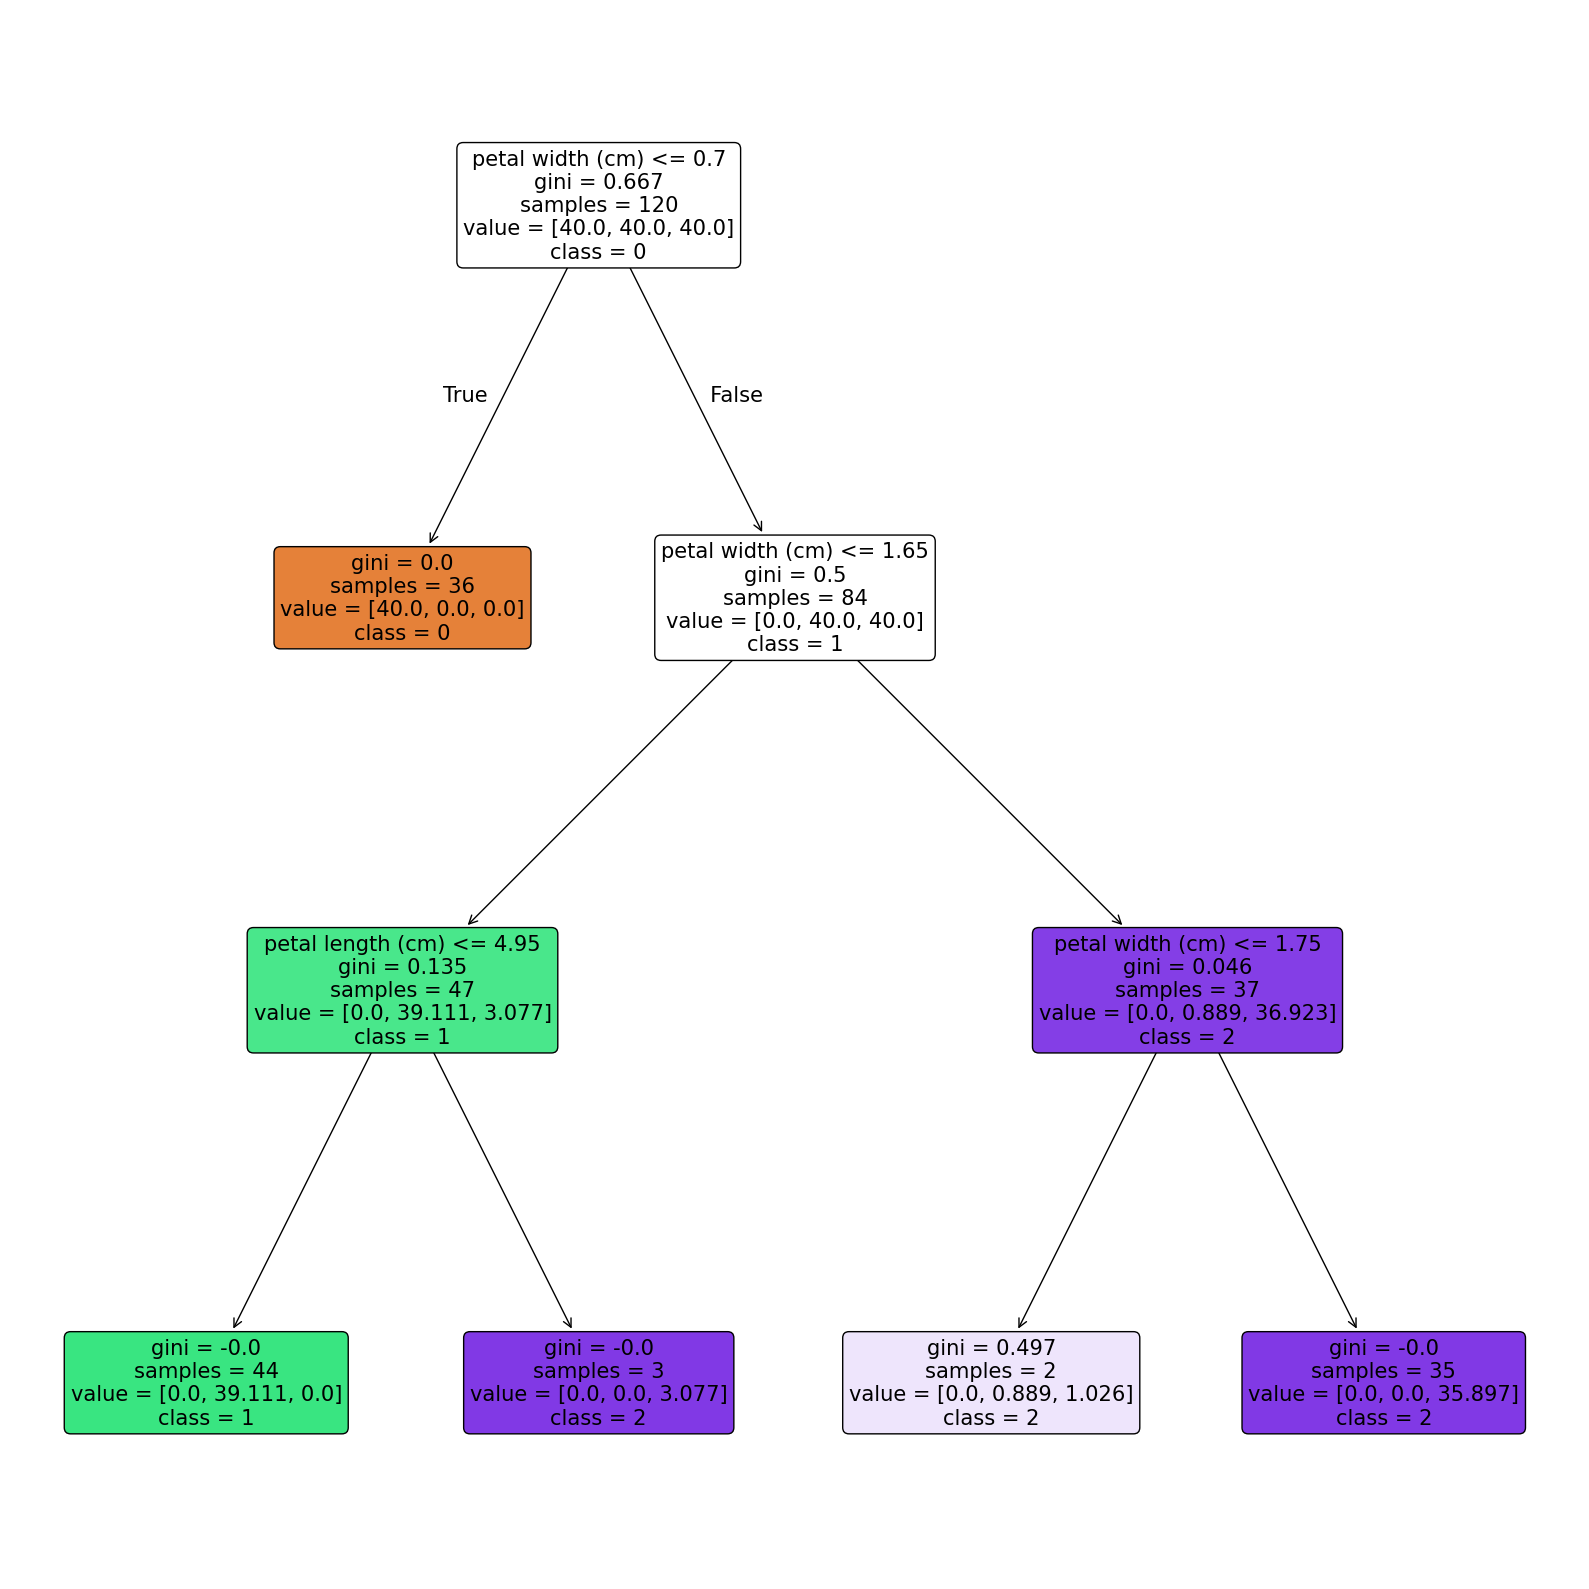

In [24]:
plt.figure(figsize=(16,16))
plot_tree(clf_tree, feature_names=X_train.columns, rounded= True,class_names=['0','1','2'], filled=True)
plt.tight_layout()
plt.show()

Interpretacion

- Glucosa es la variable que mejor separa las clases por lo quie el modelo la toma primero. Glusosa >=127,5.

In [25]:
#RocCurveDisplay.from_estimator(
#    clf_tree,
#    X_test,
#    y_test,
#    plot_chance_level=(True),
#    name="Arbol de decision",
#    alpha=0.8,
#)
#plt.grid(True)
#plt.show()

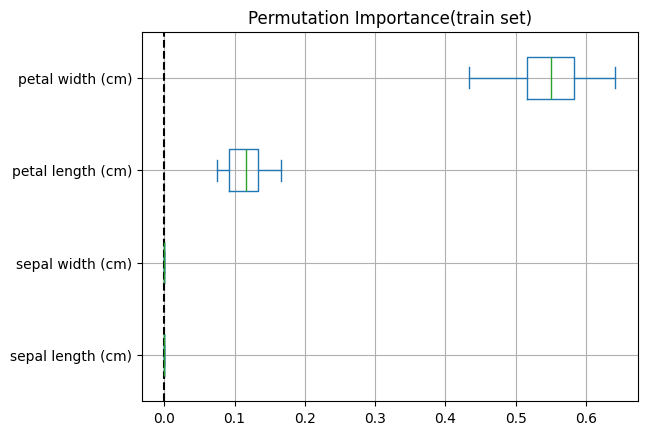

In [26]:
importance = permutation_importance(clf_tree,X_train,y_train,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

- 82%(AUC) de las veces el algoritmo va a ser correcto.

## Paso 6: Guardar modelo entrenado

In [27]:
with open("clf_tree_model.pkl", "wb") as iris_tree:
    pickle.dump(clf_tree, iris_tree)

In [28]:
with open ('../models/clf_tree_model.pkl', 'rb') as file:
    modelx = pickle.load(file)

In [29]:
predict_df = pd.DataFrame({ 'sepal length (cm)': [4.7], 'sepal width (cm)':[3.2], 'petal length (cm)':[1.3], 'petal width (cm)': [0.2]})
predict_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,4.7,3.2,1.3,0.2


In [30]:
#modelx.predict([[4.7, 3.2, 1.3, 0.2]])
modelx.predict(predict_df)

array([0])